# Non parametric


### Reload the data for simplicity

In [1]:

# Function to normalize dates relative to an election date
import pandas as pd
import os
from datetime import datetime, timedelta
import numpy as np

# Load the elections data
elections_df = pd.read_csv('DATA/Initial Data.csv')
# Main processing
all_dfs = []
csv_directory = 'DATA/INDICES/'
output_directory = 'DATA/OUTPUT/'

# Function to normalize dates relative to an election date
def normalize_dates(df, election_date):
    df['NormalizedDate'] = (df['Date'] - election_date).dt.days
    return df[(df['NormalizedDate'] >= -90) & (df['NormalizedDate'] <= 90)]

# Function to clean price data
def clean_price(price):
    if isinstance(price, str):
        return float(price.replace(',', ''))
    return float(price)

# Function to load and process index data
def process_index(file_path, election_date, index_name, election_name):
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df['Price'] = df['Price'].apply(clean_price)
    df = df.sort_values('Date')
   
    normalized_df = normalize_dates(df, election_date)
    if not normalized_df.empty:
        column_name = f"{election_name}_{index_name}"
        return normalized_df[['NormalizedDate', 'Price']].rename(columns={'Price': column_name})
    return None

for _, election in elections_df.iterrows():
    index_name = election['Index']
    election_date = pd.to_datetime(election['Date 1'])
    election_name = f"{election['Year']}_{election['Elections']}"
    filep = csv_directory + index_name + ".csv"
    file_path = os.path.abspath(filep)
    print(file_path)
    if os.path.exists(file_path):
        processed_df = process_index(file_path, election_date, index_name, election_name)
        if processed_df is not None:
            all_dfs.append(processed_df)
    else:
        print(f"Warning: File not found for index {index_name}")

if all_dfs:
    merged_df = all_dfs[0]
    for df in all_dfs[1:]:
        merged_df = pd.merge(merged_df, df, on='NormalizedDate', how='outer')
    
    # Sort by NormalizedDate
    merged_df = merged_df.sort_values('NormalizedDate')
    
    # Fill NaN values using forward fill and then backward fill
    merged_df = merged_df.ffill().bfill()
    
    # Save the final dataframe to a CSV file
    merged_df.to_csv('log_norm_election_data.csv', index=False)
    print("Processing complete. Data saved to 'log_norm_election_data.csv'")
else:
    print("No data processed. Check your input files and paths.")

c:\Users\apuza\iCloudDrive\Intesa\Political Risk\UPDATE\DATA\INDICES\FRFNN.csv
c:\Users\apuza\iCloudDrive\Intesa\Political Risk\UPDATE\DATA\INDICES\IBEXIB.csv
c:\Users\apuza\iCloudDrive\Intesa\Political Risk\UPDATE\DATA\INDICES\NLFIN.csv
c:\Users\apuza\iCloudDrive\Intesa\Political Risk\UPDATE\DATA\INDICES\BNKI.csv
c:\Users\apuza\iCloudDrive\Intesa\Political Risk\UPDATE\DATA\INDICES\FTATBNK.csv
c:\Users\apuza\iCloudDrive\Intesa\Political Risk\UPDATE\DATA\INDICES\N3020PI.csv
c:\Users\apuza\iCloudDrive\Intesa\Political Risk\UPDATE\DATA\INDICES\FTITLMS30.csv
c:\Users\apuza\iCloudDrive\Intesa\Political Risk\UPDATE\DATA\INDICES\IBEXIB.csv
c:\Users\apuza\iCloudDrive\Intesa\Political Risk\UPDATE\DATA\INDICES\IBEXIB.csv
c:\Users\apuza\iCloudDrive\Intesa\Political Risk\UPDATE\DATA\INDICES\NYK.csv
c:\Users\apuza\iCloudDrive\Intesa\Political Risk\UPDATE\DATA\INDICES\FRFNN.csv
c:\Users\apuza\iCloudDrive\Intesa\Political Risk\UPDATE\DATA\INDICES\FRFNN.csv
c:\Users\apuza\iCloudDrive\Intesa\Political 

In [5]:
import pandas as pd
import numpy as np

# Load the data
df = pd.read_csv('log_norm_election_data.csv')

# Function to calculate the non-parametric effect
def calculate_effect(election_series):
    price_0 = election_series[election_series.index == 89].values[0]
    price_1 = election_series[election_series.index == 91].values[0]
    return (price_1 - price_0) / price_0 * 100

# Calculate the effect for each election
effects = {}
for column in df.columns:
    if column != 'NormalizedDate':
        effect = calculate_effect(df[column])
        effects[column] = effect

# Convert to DataFrame
effects_df = pd.DataFrame.from_dict(effects, orient='index', columns=['Effect'])

# Filter for effects with absolute value > 1%
significant_effects = effects_df[abs(effects_df['Effect']) > 1]

# Calculate mean change
mean_change = significant_effects['Effect'].mean()

# Calculate mean change for positive and negative elections
positive_effects = significant_effects[significant_effects['Effect'] > 0]
negative_effects = significant_effects[significant_effects['Effect'] < 0]

mean_positive_change = positive_effects['Effect'].mean()
mean_negative_change = negative_effects['Effect'].mean()

# Print results
print(f"Number of elections with significant effect (>1% change): {len(significant_effects)}")
print(f"Overall mean change: {mean_change:.2f}%")
print(f"Mean positive change: {mean_positive_change:.2f}%")
print(f"Mean negative change: {mean_negative_change:.2f}%")
print("\nElections with significant positive effect:")
print(positive_effects.sort_values('Effect', ascending=False))
print("\nElections with significant negative effect:")
print(negative_effects.sort_values('Effect'))

Number of elections with significant effect (>1% change): 28
Overall mean change: 1.26%
Mean positive change: 3.45%
Mean negative change: -3.38%

Elections with significant positive effect:
                                                       Effect
2023_Greek legislative election_FTATBNK             12.467244
2023_Polish parliamentary election_BNKI              9.766830
2017_French presidential election_FRFNN              6.305495
2015_Portuguese legislative election_PTFIN           5.946338
2015_United Kingdom general election_TRINMX302020    4.060399
2022_Swedish general election_SX3010GI               3.075699
2021_Dutch general election_NLFIN                    2.483612
2023_Italian local elections_FTITLMS30               2.445199
2016_United States presidential election_NYK         2.083499
2016_United States Senate elections_NYK              2.083499
2016_United States House of Representatives ele...   2.083499
2020_United States presidential election_NYK         1.960557
2020

In [22]:
positive_effects.sort_values(by='Effect', ascending=False).head(15)

,Effect
2023_Greek legislative election_FTATBNK,12.467244
2023_Polish parliamentary election_BNKI,9.766830
2017_French presidential election_FRFNN,6.305495
2015_Portuguese legislative election_PTFIN,5.946338
2015_United Kingdom general election_TRINMX302020,4.060399
2022_Swedish general election_SX3010GI,3.075699
2021_Dutch general election_NLFIN,2.483612
2023_Italian local elections_FTITLMS30,2.445199
2016_United States presidential election_NYK,2.083499
2016_United States Senate elections_NYK,2.083499


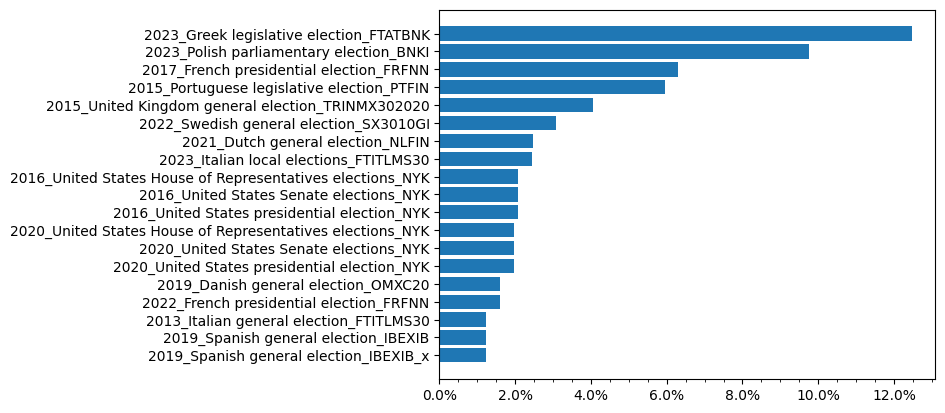

In [38]:
import matplotlib.pyplot as plt
from matplotlib import ticker
fig, ax = plt.subplots()

y = positive_effects.sort_values(by='Effect', ascending=True)['Effect']
x = positive_effects.sort_values(by='Effect', ascending=True).index
ax.barh(x,y)
# ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=100))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.5))

plt.show()




In [ ]:
def average(input):
    return np.average(input)

linear_weighted_avg_r2 = average(results_df['Linear_R2'])
non_linear_2nd_weighted_avg_r2 = average(results_df['NonLinear_2nd_R2'])
non_linear_3rd_weighted_avg_r2 = average(results_df['NonLinear_3rd_R2'])
non_linear_4th_weighted_avg_r2 = average(results_df['NonLinear_4th_R2'])
overall_mean_effect_r2 = np.mean([linear_weighted_avg_r2, non_linear_2nd_weighted_avg_r2, non_linear_3rd_weighted_avg_r2,non_linear_4th_weighted_avg_r2])
overall_mean_effect_r2


0.7923600897135856

In [ ]:
df = pd.read_csv('log_norm_election_data.csv')
df.head(10)

,NormalizedDate,2024_French Senate election_FRFNN,2023_Spanish general election_IBEXIB,2023_Dutch general election_NLFIN,2023_Polish parliamentary election_BNKI,2023_Greek legislative election_FTATBNK,2023_Finnish parliamentary election_N3020PI,2023_Italian local elections_FTITLMS30,2023_Spanish local elections_IBEXIB,2023_Spanish regional elections_IBEXIB,...,2016_Spanish general election_IBEXIB,2016_United Kingdom Brexit_TRINMX302020,2015_Portuguese legislative election_PTFIN,2015_Spanish general election_IBEXIB,2015_United Kingdom general election_TRINMX302020,2014_Swedish general election_SX3010GI,2014_Belgian federal election_BEFIN,2013_German federal election_CXPVX,2013_Italian general election_FTITLMS30,2013_Norwegian parliamentary election_OFING
0,-90,6.831878,6.405063,6.367106,9.054387,6.814894,8.011003,9.548411,6.459748,6.459748,...,6.422760,8.281539,4.598649,6.671526,8.267359,7.497623,6.384283,6.633950,9.216052,6.730397
1,-89,6.825330,6.366642,6.366488,9.075743,6.823863,8.019955,9.548411,6.491179,6.491179,...,6.422760,8.281539,4.574711,6.671526,8.267359,7.500413,6.389082,6.649244,9.214293,6.712579
2,-88,6.818968,6.361648,6.366488,9.074802,6.781069,8.031756,9.548411,6.478202,6.478202,...,6.423572,8.281539,4.595625,6.671526,8.267359,7.496442,6.383642,6.668139,9.206822,6.724433
3,-87,6.818968,6.375876,6.366488,9.070154,6.805590,8.027695,9.542984,6.478510,6.478510,...,6.400424,8.281539,4.652435,6.671526,8.257406,7.496192,6.382307,6.673715,9.245151,6.725634
4,-86,6.818968,6.335763,6.377356,9.062664,6.804260,8.027695,9.541585,6.503090,6.503090,...,6.386206,8.281539,4.702478,6.671526,8.265887,7.496192,6.391850,6.680328,9.240972,6.724613
5,-85,6.844869,6.335763,6.388528,9.062664,6.804260,8.027695,9.532011,6.503090,6.503090,...,6.386206,8.296018,4.702478,6.671526,8.262476,7.496192,6.391850,6.680328,9.240972,6.724613
6,-84,6.840183,6.335763,6.387199,9.062664,6.804260,8.027695,9.539694,6.503090,6.503090,...,6.386206,8.294962,4.702478,6.671526,8.274036,7.496192,6.391850,6.680328,9.240972,6.724613
7,-83,6.859237,6.335763,6.374087,9.070309,6.804260,8.053238,9.539694,6.517080,6.517080,...,6.380461,8.288650,4.700299,6.671526,8.278791,7.502242,6.353256,6.682910,9.251789,6.739502
8,-82,6.875779,6.305180,6.373695,9.068069,6.835120,8.046959,9.539694,6.495870,6.495870,...,6.343529,8.288650,4.687211,6.671526,8.278791,7.504105,6.382746,6.687632,9.271524,6.754627
9,-81,6.874354,6.298214,6.373695,9.065039,6.838480,8.067572,9.550371,6.506382,6.506382,...,6.338947,8.288650,4.694828,6.671526,8.278791,7.488165,6.383186,6.672084,9.266921,6.745178


In [ ]:
import pandas as pd
import numpy as np

# Load the normalized data
df = pd.read_csv('log_norm_election_data.csv')

def analyze_recovery_time(df):
    elections = df.columns[1:]  # Exclude 'NormalizedDate'
    recovery_times = []

    for election in elections:
        # Get pre-election price (at day 0 or the closest day before)
        pre_election_price = df[df['NormalizedDate'] <= 0][election].iloc[-1]
        
        # Check if there was a negative impact (price dropped after election)
        post_election_prices = df[df['NormalizedDate'] > 0][election]
        if post_election_prices.iloc[0] < pre_election_price:
            # Find the first day the price returns to or exceeds the pre-election price
            recovery_day = post_election_prices[post_election_prices > pre_election_price ].index.min()
            
            if pd.notna(recovery_day):
                recovery_time = df.loc[recovery_day, 'NormalizedDate']
                recovery_times.append((election, recovery_time))
            else:
                print(f"Warning: {election} did not recover within the analyzed period")

    return recovery_times

recovery_times = analyze_recovery_time(df)

if recovery_times:
    avg_recovery_time = np.mean([time for _, time in recovery_times])
    print(f"Average recovery time: {avg_recovery_time:.2f} days")
    
    print("\nRecovery times for each negatively impacted election:")
    for election, time in recovery_times:
        print(f"{election}: {time:.2f} days")
else:
    print("No elections with negative impact and subsequent recovery were found.")

No elections with negative impact and subsequent recovery were found.


In [ ]:
import pandas as pd
import numpy as np
from arch import arch_model
import warnings
warnings.filterwarnings('ignore')

# Load the data
data = pd.read_csv('log_norm_election_data.csv')
data.set_index('NormalizedDate', inplace=True)

def fit_figarch_and_get_volatility(series):
    # Remove NaN values
    series = series.dropna()
    
    # Reverse the series for FIGARCH modeling
    
    # Fit FIGARCH(1,d,1) model
    model = arch_model(series, vol='FIGARCH', p=1, o=0 ,q=0)
    
    try:
        results = model.fit(disp='off')
        # Extract conditional volatility
        volatility = np.sqrt(results.conditional_volatility)
        # Reverse the volatility series back to original order
        return pd.Series(volatility, index=series.index)
    except:
        print(f"Failed to fit EGARCH model for {series.name}")
        return pd.Series(index=series.index)

# Apply FIGARCH to each election time series and store results
volatilitydf = pd.DataFrame()
for column in data.columns:
    if column != 'NormalizedDate':
        volatility_column = f"{column}_volatility"
        volatilitydf[volatility_column] = fit_figarch_and_get_volatility(data[column])

# Save the results
volatilitydf.to_csv('election_data_with_figarch_volatility_corrected.csv')
print("Corrected FIGARCH volatility analysis complete. Results saved to 'election_data_with_figarch_volatility_corrected.csv'")

Corrected FIGARCH volatility analysis complete. Results saved to 'election_data_with_figarch_volatility_corrected.csv'


In [ ]:
volatilitydf.count()

2024_French Senate election_FRFNN_volatility                            181
2023_Spanish general election_IBEXIB_volatility                         181
2023_Dutch general election_NLFIN_volatility                            181
2023_Polish parliamentary election_BNKI_volatility                      181
2023_Greek legislative election_FTATBNK_volatility                      181
2023_Finnish parliamentary election_N3020PI_volatility                  181
2023_Italian local elections_FTITLMS30_volatility                       181
2023_Spanish local elections_IBEXIB_volatility                          181
2023_Spanish regional elections_IBEXIB_volatility                       181
2022_United States elections_NYK_volatility                             181
2022_French presidential election_FRFNN_volatility                      181
2022_French legislative election_FRFNN_volatility                       181
2022_Swedish general election_SX3010GI_volatility                       181
2022_Italian

In [ ]:
import pandas as pd
import numpy as np
from arch import arch_model
import warnings
warnings.filterwarnings('ignore')

# Load the data
volatilitydf = pd.read_csv('election_data_with_figarch_volatility_corrected.csv')
volatilitydf.set_index('NormalizedDate', inplace=True)

# Function to calculate average volatility for 10 days prior to election
def calculate_pre_election_volatility(df):
    volatility_data = {}
    
    for column in df.columns:
        if column.endswith('_volatility'):
            # Extract the election name (remove '_volatility' suffix)
            election_name = column[:-11]
            
            # Select data for 10 days prior to election (-10 to -1)
            pre_election_data = df.loc[-10:-1, column]
            
            # Calculate average volatility
            avg_volatility = pre_election_data.mean()
            
            volatility_data[election_name] = avg_volatility
    
    return pd.Series(volatility_data)

# Calculate pre-election volatility for each election
volatility_data = calculate_pre_election_volatility(volatilitydf)

# Display results
print("Average volatility for 10 days prior to each election:")
print(volatility_data)
volatility_data.to_csv("pre_election_volatility.csv")


Average volatility for 10 days prior to each election:
2024_French Senate election_FRFNN                            0.089542
2023_Spanish general election_IBEXIB                         0.138591
2023_Dutch general election_NLFIN                            0.165871
2023_Polish parliamentary election_BNKI                      0.250429
2023_Greek legislative election_FTATBNK                      0.402735
2023_Finnish parliamentary election_N3020PI                  0.213641
2023_Italian local elections_FTITLMS30                       0.171585
2023_Spanish local elections_IBEXIB                          0.202884
2023_Spanish regional elections_IBEXIB                       0.202884
2022_United States elections_NYK                             0.176038
2022_French presidential election_FRFNN                      0.196732
2022_French legislative election_FRFNN                       0.121106
2022_Swedish general election_SX3010GI                       0.154320
2022_Italian general election_FTITL

In [ ]:
binary_effect_data = pd.DataFrame(index=results_df.index)
binary_effect_data['Effect'] = (results_df['Mean_Effect'] < 0).astype(int)
print("\nBinary Classification of Election Effects:")
print(binary_effect_data)
binary_effect_data.to_csv('election_effect_classification.csv')

print("\nBinary classification dataset saved as 'election_effect_classification.csv'")


Binary Classification of Election Effects:
                                                    Effect
2024_French Senate election_FRFNN                        0
2023_Spanish general election_IBEXIB                     0
2023_Dutch general election_NLFIN                        0
2023_Polish parliamentary election_BNKI                  0
2023_Greek legislative election_FTATBNK                  0
2023_Finnish parliamentary election_N3020PI              0
2023_Italian local elections_FTITLMS30                   0
2023_Spanish local elections_IBEXIB                      0
2023_Spanish regional elections_IBEXIB                   0
2022_United States elections_NYK                         0
2022_French presidential election_FRFNN                  0
2022_French legislative election_FRFNN                   1
2022_Swedish general election_SX3010GI                   0
2022_Italian general election_FTITLMS30                  1
2021_German federal election_CXPVX                       1
2021_Norwegi

In [ ]:
def analyze_election_prices(data):
    # Convert the 'NormalizedDate' column to integer
    data['NormalizedDate'] = data['NormalizedDate'].astype(int)

    # Initialize a dictionary to store results
    results = {}

    # Iterate through all columns except 'NormalizedDate'
    for column in data.columns[1:]:
        # Filter data for the range [-90, -1]
        pre_election_data = data[(data['NormalizedDate'] >= -90) & (data['NormalizedDate'] <= -1)][['NormalizedDate', column]]
        
        # Calculate the median for the range [-90, -1]
        median_90_to_1 = pre_election_data[column].median()
        
        # Calculate the average for the range [-10, -1]
        avg_10_to_1 = pre_election_data[
            (pre_election_data['NormalizedDate'] >= -10) & 
            (pre_election_data['NormalizedDate'] <= -1)
        ][column].mean()
        
        # Calculate the spread
        spread = avg_10_to_1 - median_90_to_1
        
        # Store the result
        results[column] = spread

    # Create a DataFrame from the results
    result_df = pd.DataFrame.from_dict(results, orient='index', columns=['Spread'])
    return result_df

# Load the data
result_df = pd.read_csv('log_norm_election_data.csv')

# Run the analysis
spread_data = analyze_election_prices(result_df)


spread_data.to_csv('election_price_spread_analysis.csv')



# Display the results
print(spread_data.count)

<bound method DataFrame.count of                                                       Spread
2024_French Senate election_FRFNN                   0.000000
2023_Spanish general election_IBEXIB                0.082518
2023_Dutch general election_NLFIN                   0.008645
2023_Polish parliamentary election_BNKI             0.011162
2023_Greek legislative election_FTATBNK             0.063145
2023_Finnish parliamentary election_N3020PI        -0.064800
2023_Italian local elections_FTITLMS30              0.000187
2023_Spanish local elections_IBEXIB                -0.031617
2023_Spanish regional elections_IBEXIB             -0.031617
2022_United States elections_NYK                   -0.006084
2022_French presidential election_FRFNN            -0.071794
2022_French legislative election_FRFNN             -0.022760
2022_Swedish general election_SX3010GI             -0.000697
2022_Italian general election_FTITLMS30             0.044366
2021_German federal election_CXPVX                 -

In [ ]:

# Load the data
spread_data = pd.read_csv('election_price_spread_analysis.csv', index_col=0)
volatility_data = pd.read_csv('pre_election_volatility.csv', index_col=0)
binary_effect_data = pd.read_csv('election_effect_classification.csv', index_col=0)



In [ ]:
binary_effect_data

,Effect
2024_French Senate election_FRFNN,0
2023_Spanish general election_IBEXIB,0
2023_Dutch general election_NLFIN,0
2023_Polish parliamentary election_BNKI,0
2023_Greek legislative election_FTATBNK,0
2023_Finnish parliamentary election_N3020PI,0
2023_Italian local elections_FTITLMS30,0
2023_Spanish local elections_IBEXIB,0
2023_Spanish regional elections_IBEXIB,0
2022_United States elections_NYK,0


## Forecasting the effect of the direction of the election using Volatility and Price

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Load the data
spread_data = pd.read_csv('election_price_spread_analysis.csv', index_col=0)
volatility_data = pd.read_csv('pre_election_volatility.csv', index_col=0)
binary_effect_data = pd.read_csv('election_effect_classification.csv', index_col=0)

# Reset index for volatility_data to match the other datasets
volatility_data = volatility_data.reset_index()
volatility_data.index = spread_data.index
volatility_data = volatility_data.drop(columns=['index'])

# Combine spread and volatility
X = pd.merge(spread_data, volatility_data, left_index=True, right_index=True, how='inner')

# Ensure all datasets have the same index
common_index = X.index.intersection(binary_effect_data.index)
X = X.loc[common_index]
y = binary_effect_data.loc[common_index, 'Effect']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the logistic regression model
model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Print model coefficients
print("\nModel Coefficients:")
for feature, coef in zip(X.columns, model.coef_[0]):
    print(f"{feature}: {coef}")

# Print model intercept
print(f"\nIntercept: {model.intercept_[0]}")

# Calculate and print odds ratios
print("\nOdds Ratios:")
odds_ratios = np.exp(model.coef_[0])
for feature, odds_ratio in zip(X.columns, odds_ratios):
    print(f"{feature}: {odds_ratio}")
    


Confusion Matrix:
[[10  2]
 [ 1  2]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.83      0.87        12
           1       0.50      0.67      0.57         3

    accuracy                           0.80        15
   macro avg       0.70      0.75      0.72        15
weighted avg       0.83      0.80      0.81        15


Model Coefficients:
Spread: 0.597252573715465
0: 0.3183827715732305

Intercept: -0.17757547558236816

Odds Ratios:
Spread: 1.8171195340073873
0: 1.3749024340868643
